# Bengaluru Temperature Prediction Project

## Objective
This project aims to predict the next day's average temperature in Bengaluru, Karnataka, India, using historical weather data from 2014 to 2024. We use a Ridge regression model, evaluate its performance, and visualize results to understand temperature patterns and model accuracy.

## Dataset
- **Source**: `weather_data.csv`
- **Features**: Temperature, Minimum/Maximum Temperature, Dew Point, Relative Humidity, Sea Level Pressure, Visibility, Cloud Cover, etc.
- **Target**: Next day's average temperature (`target`)
- **Period**: January 1, 2014, to January 1, 2024 (~6695 rows)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
plt.style.use('seaborn-v0_8')
%matplotlib inline

# data loading

In [3]:
# load the dataset
weather = pd.read_csv('weather_data.csv')
print('dataset Info:')
weather.info()
print('\nfirst 5 Rows:')
weather.head()
print('\nduplicate dates:', weather['Date time'].duplicated().sum())

dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Address              6695 non-null   object 
 1   Date time            6695 non-null   object 
 2   Minimum Temperature  6695 non-null   float64
 3   Maximum Temperature  6695 non-null   float64
 4   Temperature          6695 non-null   float64
 5   Dew Point            6695 non-null   float64
 6   Relative Humidity    6695 non-null   float64
 7   Heat Index           5157 non-null   float64
 8   Wind Speed           6695 non-null   float64
 9   Wind Gust            397 non-null    float64
 10  Wind Direction       6692 non-null   float64
 11  Wind Chill           0 non-null      float64
 12  Precipitation        6695 non-null   float64
 13  Precipitation Cover  6695 non-null   float64
 14  Snow Depth           0 non-null      float64
 15  Visibility           669

## Data Preprocessing

In [4]:
weather['Date time'] = pd.to_datetime(weather['Date time'], format='%m/%d/%Y', errors='coerce')
weather = weather.groupby('Date time').mean(numeric_only=True).reset_index()
#drop unnecessary columns
columns_to_drop = ['Address', 'Resolved Address', 'Name', 'Info', 'Conditions', 'Weather Type', 'Latitude', 'Longitude', 'Heat Index', 'Wind Speed', 'Wind Gust', 'Wind Direction', 'Wind Chill', 'Precipitation', 'Precipitation Cover']
weather = weather.drop(columns=[col for col in columns_to_drop if col in weather.columns])
#create target (next day's temperature)
weather['target'] = weather['Temperature'].shift(-1)

weather['temp_prev'] = weather['Temperature'].shift(1)
weather['maxtemp_prev'] = weather['Maximum Temperature'].shift(1)
weather['mintemp_prev'] = weather['Minimum Temperature'].shift(1)

#extract datetime features
weather['year'] = weather['Date time'].dt.year
weather['month'] = weather['Date time'].dt.month
weather['day'] = weather['Date time'].dt.day

#handle missing values
numeric_cols = weather.select_dtypes(include=[np.number]).columns
weather[numeric_cols] = weather[numeric_cols].fillna(weather[numeric_cols].mean())

# Verify no duplicates or missing values
print('Duplicates after aggregation:', weather['Date time'].duplicated().sum())
print('Missing values:\n', weather.isna().sum())

weather.head()

Duplicates after aggregation: 0
Missing values:
 Date time                 0
Minimum Temperature       0
Maximum Temperature       0
Temperature               0
Dew Point                 0
Relative Humidity         0
Snow Depth             3653
Visibility                0
Cloud Cover               0
Sea Level Pressure        0
target                    0
temp_prev                 0
maxtemp_prev              0
mintemp_prev              0
year                      0
month                     0
day                       0
dtype: int64


,Date time,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,target,temp_prev,maxtemp_prev,mintemp_prev,year,month,day
0,2014-01-01,65.00,84.10,76.70,60.90,59.230,NaN,5.50,69.40,1018.00,75.60,80.619578,84.389677,75.121358,2014,1,1
1,2014-01-02,70.40,82.30,75.60,60.15,60.105,NaN,4.65,53.90,1018.25,72.50,76.700000,84.100000,65.000000,2014,1,2
2,2014-01-03,69.80,74.85,72.50,60.65,68.165,NaN,5.95,36.80,1017.90,81.35,75.600000,82.300000,70.400000,2014,1,3
3,2014-01-04,71.45,88.60,81.35,46.75,31.370,NaN,5.90,57.50,1016.80,79.30,72.500000,74.850000,69.800000,2014,1,4
4,2014-01-05,72.25,84.10,79.30,55.05,49.375,NaN,5.35,23.75,1016.10,84.50,81.350000,88.600000,71.450000,2014,1,5


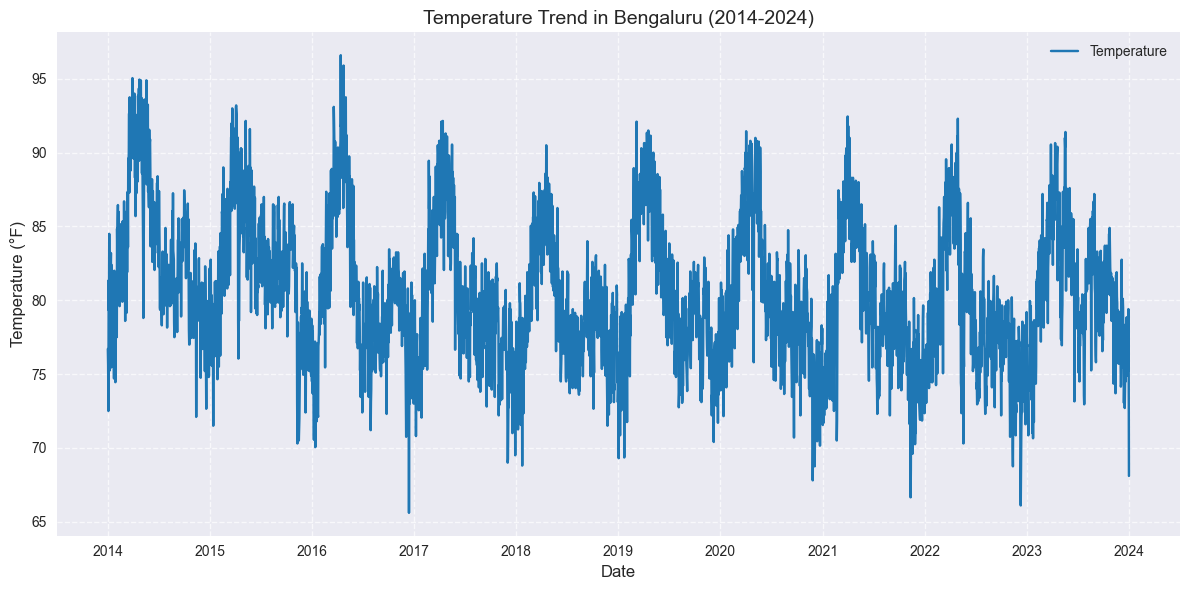

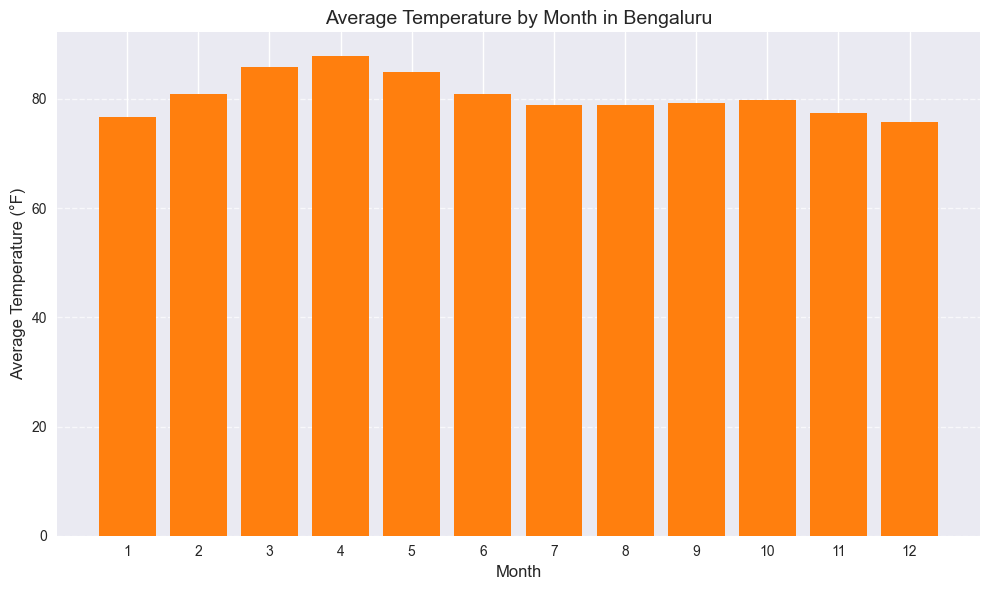

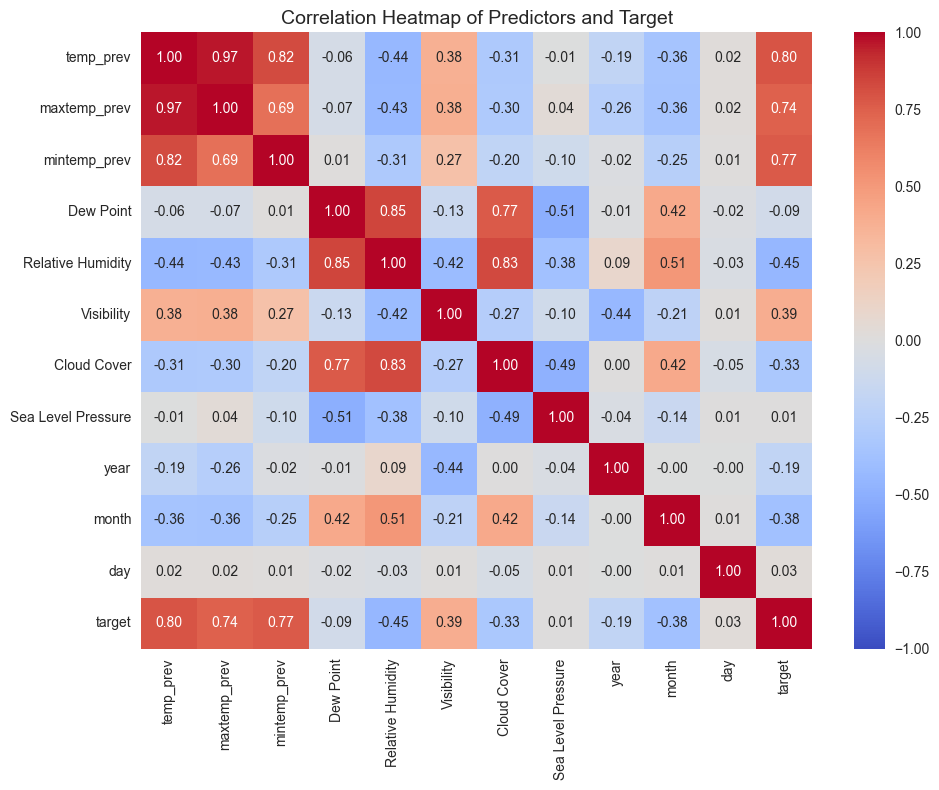

In [5]:
# Temperature trend over time
plt.figure(figsize=(12, 6))
plt.plot(weather['Date time'], weather['Temperature'], color='#1f77b4', label='Temperature')
plt.title('Temperature Trend in Bengaluru (2014-2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/temperature_trend.png', dpi=300)
plt.show()

# Monthly average temperature
monthly_avg = weather.groupby('month')['Temperature'].mean()
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg.index, monthly_avg.values, color='#ff7f0e')
plt.title('Average Temperature by Month in Bengaluru', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Temperature (°F)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.savefig('plots/monthly_avg_temperature.png', dpi=300)
plt.show()

# Correlation heatmap
predictors = ['temp_prev', 'maxtemp_prev', 'mintemp_prev', 'Dew Point', 'Relative Humidity', 'Visibility', 'Cloud Cover', 'Sea Level Pressure', 'year', 'month', 'day']
plt.figure(figsize=(10, 8))
sns.heatmap(weather[predictors + ['target']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Predictors and Target', fontsize=14)
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png', dpi=300)
plt.show()

## Model Training and Backtesting

In [6]:
# Define predictors
predictors = ['temp_prev', 'maxtemp_prev', 'mintemp_prev', 'Dew Point', 'Relative Humidity', 'Visibility', 'Cloud Cover', 'Sea Level Pressure', 'year', 'month', 'day']

# Initialize Ridge model
rr = Ridge(alpha=0.1)
def backtest(weather, model, predictors, start=1825, step=50):
    all_predictions = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i]
        test = weather.iloc[i:(i+step)]
        X_train = train[predictors].values.astype('float32')
        y_train = train['target'].values.astype('float32')
        X_test = test[predictors].values.astype('float32')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds = pd.Series(preds, index=test.index, name='predicted')
        combined = pd.concat([test['target'], preds], axis=1)
        combined['change'] = (combined['predicted'] - combined['target']).abs()
        all_predictions.append(combined)
    return pd.concat(all_predictions)
# Run backtest
predictions = backtest(weather, rr, predictors)

# Display predictions
print('Predictions:')
predictions.head()

Predictions:


,target,predicted,change
1825,74.55,74.751160,0.201160
1826,69.30,71.057556,1.757556
1827,76.45,73.543884,2.906116
1828,74.60,71.269409,3.330591
1829,74.10,75.808838,1.708838


## Model Evaluation

In [7]:
# Calculate metrics
mae = mean_absolute_error(predictions['target'], predictions['predicted'])
rmse = np.sqrt(mean_squared_error(predictions['target'], predictions['predicted']))
r2 = r2_score(predictions['target'], predictions['predicted'])

print(f'Ridge Regression Metrics:')
print(f'Mean Absolute Error: {mae:.4f} °F')
print(f'Root Mean Squared Error: {rmse:.4f} °F')
print(f'R² Score: {r2:.4f}')

Ridge Regression Metrics:
Mean Absolute Error: 2.0279 °F
Root Mean Squared Error: 2.5504 °F
R² Score: 0.7041


## Visualizations of Model Performance
Visualize actual vs. predicted temperatures, residuals, and error distribution to assess model performance.

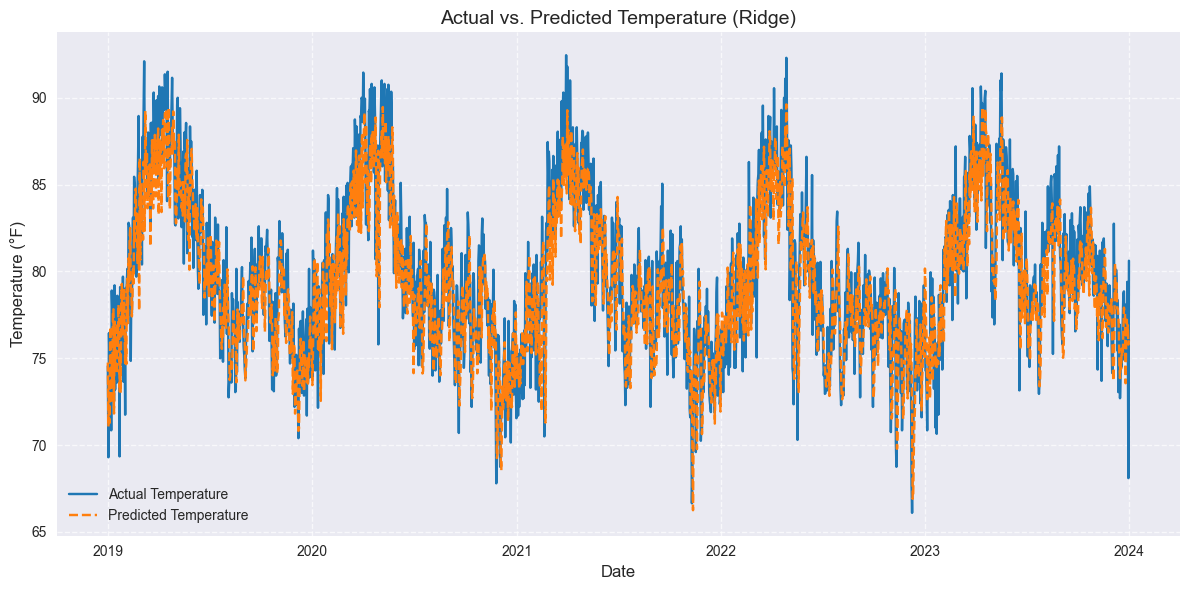

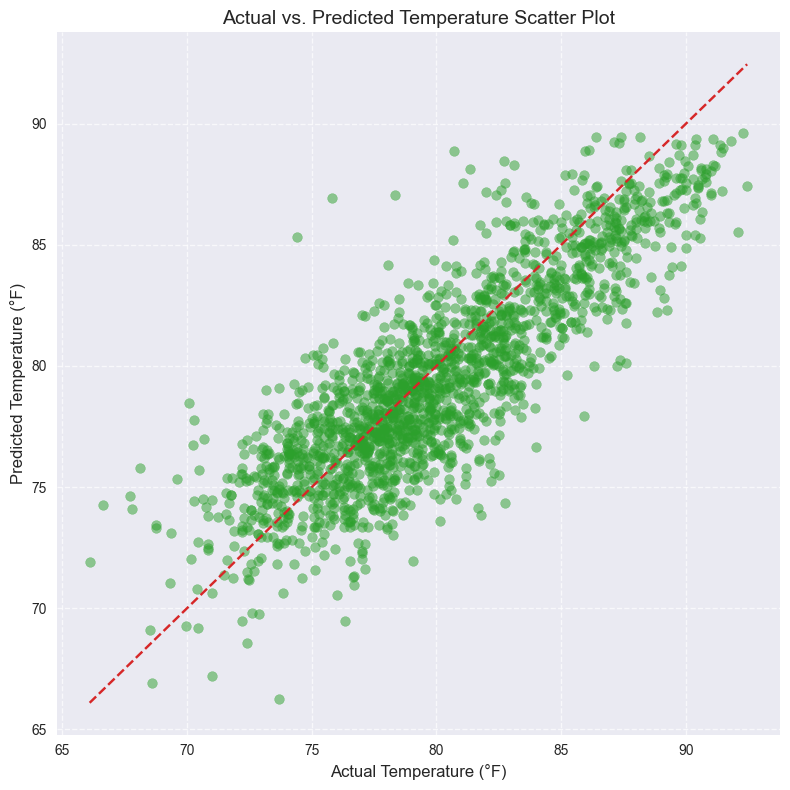

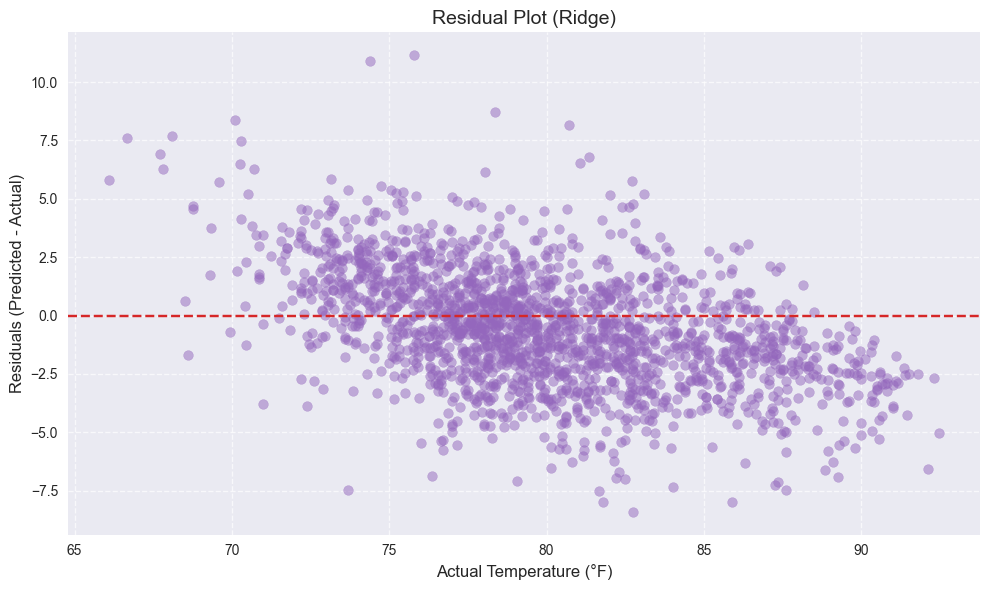

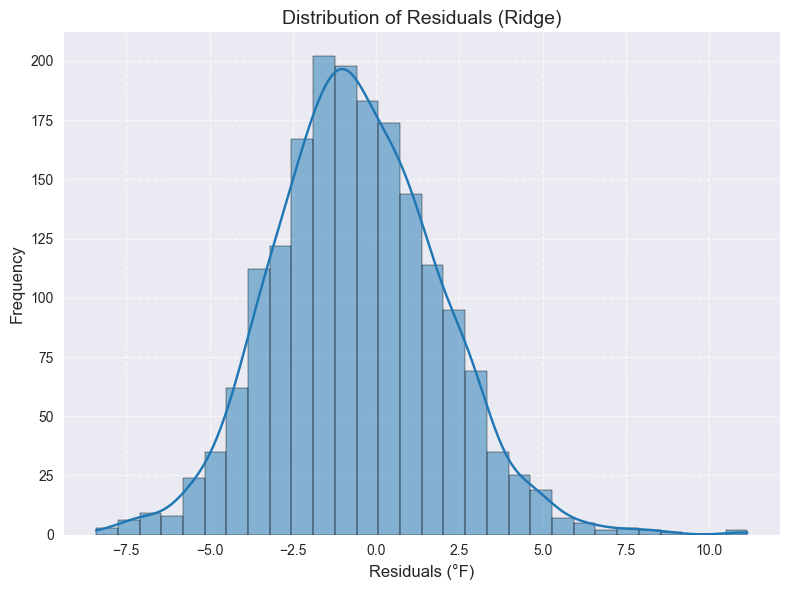

In [8]:
# Actual vs. Predicted Temperature
plt.figure(figsize=(12, 6))
plt.plot(weather.loc[predictions.index, 'Date time'], predictions['target'], label='Actual Temperature', color='#1f77b4')
plt.plot(weather.loc[predictions.index, 'Date time'], predictions['predicted'], label='Predicted Temperature', color='#ff7f0e', linestyle='--')
plt.title('Actual vs. Predicted Temperature (Ridge)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/actual_vs_predicted_temperature.png', dpi=300)
plt.show()

# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(predictions['target'], predictions['predicted'], alpha=0.5, color='#2ca02c')
plt.plot([predictions['target'].min(), predictions['target'].max()],
         [predictions['target'].min(), predictions['target'].max()],
         color='#d62728', linestyle='--')
plt.title('Actual vs. Predicted Temperature Scatter Plot', fontsize=14)
plt.xlabel('Actual Temperature (°F)', fontsize=12)
plt.ylabel('Predicted Temperature (°F)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/scatter_actual_vs_predicted.png', dpi=300)
plt.show()

# Residual plot
residuals = predictions['predicted'] - predictions['target']
plt.figure(figsize=(10, 6))
plt.scatter(predictions['target'], residuals, alpha=0.5, color='#9467bd')
plt.axhline(y=0, color='#d62728', linestyle='--')
plt.title('Residual Plot (Ridge)', fontsize=14)
plt.xlabel('Actual Temperature (°F)', fontsize=12)
plt.ylabel('Residuals (Predicted - Actual)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/residual_plot.png', dpi=300)
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='#1f77b4')
plt.title('Distribution of Residuals (Ridge)', fontsize=14)
plt.xlabel('Residuals (°F)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/residuals_histogram.png', dpi=300)
plt.show()

## Model Improvement: Random Forest and Feature Engineering

In [9]:
# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_predictions = backtest(weather, rf, predictors)

# Evaluate Random Forest
rf_mae = mean_absolute_error(rf_predictions['target'], rf_predictions['predicted'])
rf_rmse = np.sqrt(mean_squared_error(rf_predictions['target'], rf_predictions['predicted']))
rf_r2 = r2_score(rf_predictions['target'], rf_predictions['predicted'])

print(f'Random Forest Metrics:')
print(f'Mean Absolute Error: {rf_mae:.4f} °F')
print(f'Root Mean Squared Error: {rf_rmse:.4f} °F')
print(f'R² Score: {rf_r2:.4f}')

# Feature engineering: Add rolling averages and seasonal indicators
weather['temp_rolling_7d'] = weather['Temperature'].rolling(window=7).mean()
weather['humidity_rolling_7d'] = weather['Relative Humidity'].rolling(window=7).mean()
weather['month_sin'] = np.sin(2 * np.pi * weather['month'] / 12)
weather['month_cos'] = np.cos(2 * np.pi * weather['month'] / 12)

# Update predictors
new_predictors = predictors + ['temp_rolling_7d', 'humidity_rolling_7d', 'month_sin', 'month_cos']
new_predictors = [col for col in new_predictors if col in weather.columns]

# Handle missing values in new predictors
weather[new_predictors] = weather[new_predictors].fillna(weather[new_predictors].mean())

# Backtest with new predictors
new_predictions = backtest(weather, rr, new_predictors)
new_mae = mean_absolute_error(new_predictions['target'], new_predictions['predicted'])
new_rmse = np.sqrt(mean_squared_error(new_predictions['target'], new_predictions['predicted']))
new_r2 = r2_score(new_predictions['target'], new_predictions['predicted'])

print(f'Ridge with New Features Metrics:')
print(f'Mean Absolute Error: {new_mae:.4f} °F')
print(f'Root Mean Squared Error: {new_rmse:.4f} °F')
print(f'R² Score: {new_r2:.4f}')

Random Forest Metrics:
Mean Absolute Error: 1.9524 °F
Root Mean Squared Error: 2.4906 °F
R² Score: 0.7178
Ridge with New Features Metrics:
Mean Absolute Error: 1.8971 °F
Root Mean Squared Error: 2.3753 °F
R² Score: 0.7433


## analysing features

Feature Importances:
 temp_prev             0.601255
mintemp_prev          0.129356
Relative Humidity     0.039801
Cloud Cover           0.038355
month                 0.033239
Sea Level Pressure    0.028619
Dew Point             0.028275
year                  0.027986
Visibility            0.025803
maxtemp_prev          0.024700
day                   0.022611
dtype: float64


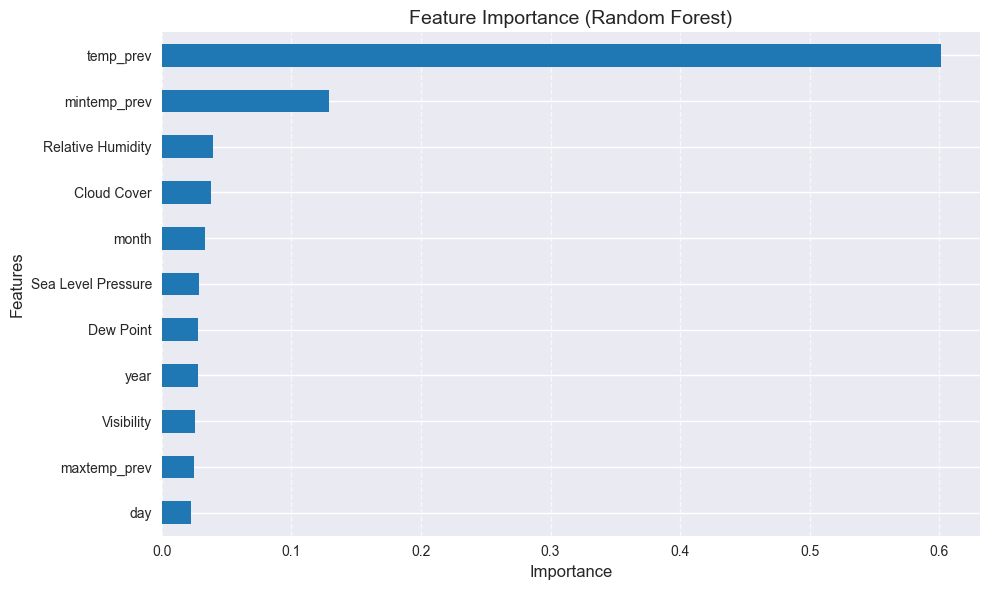

In [10]:
# Train Random Forest on full dataset for feature importance
try:
    rf.fit(weather[predictors].values.astype('float32'), weather['target'].values.astype('float32'))
    importances = pd.Series(rf.feature_importances_, index=predictors)

    # Debug: Print importances
    print('Feature Importances:\n', importances.sort_values(ascending=False))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    importances.sort_values().plot(kind='barh', color='#1f77b4')
    plt.title('Feature Importance (Random Forest)', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    plt.tight_layout()
    plt.savefig('plots/feature_importance.png', dpi=300)
    plt.show()
except Exception as e:
    print(f'Error in Feature Importance: {e}')